<a href="https://colab.research.google.com/github/talpt/pyton/blob/main/Maestro_NQQE_Reversal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Cloning https://github.com/rongardF/tvdatafeed to /tmp/pip-req-build-zqyeem4e
  Running command git clone --filter=blob:none --quiet https://github.com/rongardF/tvdatafeed /tmp/pip-req-build-zqyeem4e
  Resolved https://github.com/rongardF/tvdatafeed to commit e6f6aaa7de439ac6e454d9b26d2760ded8dc4923
  Preparing metadata (setup.py) ... done

Zaman Aralığını Seçin:
1: 15 Dakika
2: 30 Dakika
3: 45 Dakika
4: 1 Saat
5: 2 Saat
6: 4 Saat
7: Günlük
8: Haftalık
9: Aylık
Seçiminiz: 7


AKYHO 2.9 True 2025-01-10 06:00:00
ALCTL 122.6 True 2025-01-10 06:00:00
ARTMS 30.06 True 2025-01-10 06:00:00
BASGZ 31.16 True 2025-01-10 06:00:00
BOBET 23.66 True 2025-01-10 06:00:00
CELHA 22.96 True 2025-01-10 06:00:00
CRFSA 103.8 True 2025-01-10 06:00:00
DCTTR 29.24 True 2025-01-10 06:00:00
EGPRO 171.2 True 2025-01-10 06:00:00
ELITE 38.44 True 2025-01-10 06:00:00
ERSU 17.52 True 2025-01-10 06:00:00
EUPWR 33.3 True 2025-01-10 06:00:00
GRSEL 204.8 True 2025-01-10 06:00:00
GUNDG 62.95 True 2025-01-10 06:00:00
HKTM 16.54 True 2025-01-10 06:00:00
INFO 2.79 True 2025-01-10 06:00:00
KARYE 28.8 True 2025-01-10 06:00:00
KLSER 36.4 True 2025-01-10 06:00:00
KOCMT 17.34 True 2025-01-10 06:00:00
KONTR 38.56 True 2025-01-10 06:00:00
KOZAL 22.9 True 2025-01-10 06:00:00
KUTPO 81.15 True 2025-01-10 06:00:00
LINK 491.5 True 2025-01-10 06:00:00
MGROS 536.5 True 2025-01-10 06:00:00
NTHOL 44.18 True 2025-01-10 06:00:00
ODAS 6.2 True 2025-01-10 06:00:00
ORGE 86.8 True 2025-01-10 06:00:00
OZYSR 27.52 True 

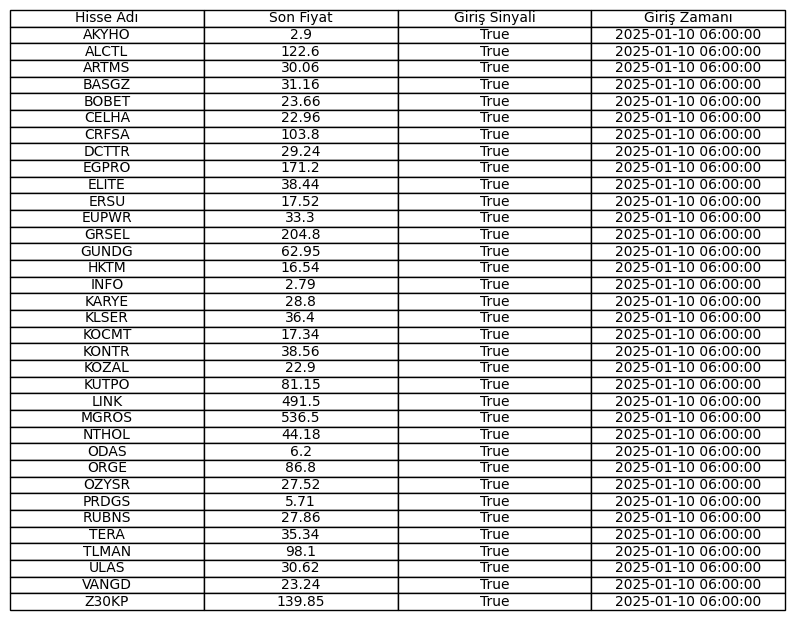

In [ ]:
!pip install git+https://github.com/rongardF/tvdatafeed  backtesting
!pip install tradingview-screener==2.5.0

import pandas as pd
import numpy as np
from tvDatafeed import TvDatafeed, Interval
from tradingview_screener import get_all_symbols
import warnings
import matplotlib.pyplot as plt
from tabulate import tabulate

warnings.simplefilter(action='ignore', category=FutureWarning)

# EMA ve RSI fonksiyonları
def ema(series, length):
    return series.ewm(span=length, adjust=False).mean()

def rsi(series, length):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=length).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=length).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def NQQE(data, RSI_Period=14, SF=5, QQE=4.238, ThreshHold=10):
    # RSI hesaplaması
    src = data['Close']
    Wilders_Period = RSI_Period * 2 - 1

    Rsi = rsi(src, RSI_Period)
    RsiMa = ema(Rsi, SF)

    AtrRsi = abs(RsiMa.diff())
    MaAtrRsi = ema(AtrRsi, Wilders_Period)
    dar = ema(MaAtrRsi, Wilders_Period) * QQE

    # Trend hesaplamaları
    longband = np.zeros(len(data))
    shortband = np.zeros(len(data))
    trend = np.zeros(len(data))

    # QQE Çizgileri
    RSIndex = RsiMa
    newshortband = RSIndex + dar
    newlongband = RSIndex - dar

    for i in range(1, len(data)):
        # Trend Değişimi
        if RSIndex[i-1] > longband[i-1] and RSIndex[i] > longband[i-1]:
            longband[i] = max(longband[i-1], newlongband[i])
        else:
            longband[i] = newlongband[i]

        if RSIndex[i-1] < shortband[i-1] and RSIndex[i] < shortband[i-1]:
            shortband[i] = min(shortband[i-1], newshortband[i])
        else:
            shortband[i] = newshortband[i]

        # QQE Çaprazı Kontrolü
        if RSIndex[i] > shortband[i-1]:
            trend[i] = 1
        elif RSIndex[i] < longband[i-1]:
            trend[i] = -1
        else:
            trend[i] = trend[i-1]

    # Çapraz kontrolü
    qqeLong = np.zeros(len(data))
    qqeShort = np.zeros(len(data))

    for i in range(1, len(data)):
        if trend[i] == 1 and trend[i-1] == -1:
            qqeLong[i] = RSIndex[i] - 50
        if trend[i] == -1 and trend[i-1] == 1:
            qqeShort[i] = RSIndex[i] - 50

    data['Trend'] = trend
    data['QQE Long'] = qqeLong
    data['QQE Short'] = qqeShort
    data['Long Band'] = longband
    data['Short Band'] = shortband

    return data

# Zaman aralıkları
intervals = {
    '1': ('15 Dakika', Interval.in_15_minute),
    '2': ('30 Dakika', Interval.in_30_minute),
    '3': ('45 Dakika', Interval.in_45_minute),
    '4': ('1 Saat', Interval.in_1_hour),
    '5': ('2 Saat', Interval.in_2_hour),
    '6': ('4 Saat', Interval.in_4_hour),
    '7': ('Günlük', Interval.in_daily),
    '8': ('Haftalık', Interval.in_weekly),
    '9': ('Aylık', Interval.in_monthly)
}

# Kullanıcıdan zaman aralığı seçimi
print("\nZaman Aralığını Seçin:")
for key, (name, _) in intervals.items():
    print(f"{key}: {name}")

choice = input("Seçiminiz: ")
selected_interval = intervals.get(choice, intervals['4'])[1]  # Varsayılan olarak '1 Saat' seçiliyor

tv = TvDatafeed()
Hisseler = get_all_symbols(market='turkey')
Hisseler = [symbol.replace('BIST:', '') for symbol in Hisseler]
Hisseler = sorted(Hisseler)

Titles = ['Hisse Adı', 'Son Fiyat', 'Giriş Sinyali', 'Giriş Zamanı']
df_signals = pd.DataFrame(columns=Titles)

new_rows = []

for symbol in Hisseler:
    try:
        data = tv.get_hist(symbol=symbol, exchange='BIST', interval=selected_interval, n_bars=500)
        data = data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})
        data = data.reset_index()
        nqqeTrend = NQQE(data, RSI_Period=14, SF=5, QQE=4.238, ThreshHold=10)
        nqqeTrend['datetime'] = pd.to_datetime(nqqeTrend['datetime'])
        nqqeTrend.set_index('datetime', inplace=True)
        Signals = nqqeTrend.tail(2).reset_index()
        Buy = Signals.loc[0, 'Trend'] == -1 and Signals.loc[1, 'Trend'] == 1
        Last_Price = Signals.loc[1, 'Close']
        Entry_Time = Signals.loc[1, 'datetime']
        if Buy:
            new_rows.append({'Hisse Adı': symbol, 'Son Fiyat': Last_Price, 'Giriş Sinyali': str(Buy), 'Giriş Zamanı': Entry_Time})
            print(symbol, Last_Price, Buy, Entry_Time)
    except Exception as e:
        print(f"Error processing {symbol}: {e}")

df_signals = pd.concat([df_signals, pd.DataFrame(new_rows)], ignore_index=True)

df_True = df_signals[df_signals['Giriş Sinyali'] == 'True']

print(tabulate(df_True, headers='keys', tablefmt='grid'))

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_True.values, colLabels=df_True.columns, cellLoc='center', loc='center')
plt.show()

